# Proyek Klasifikasi Gambar: GTSRB - German Traffic Sign Recognition Benchmark
- **Nama:** Yoga Adi Tandanu
- **Email:** yogaaditandanu@gmail.com
- **ID Dicoding:** yogaaditandanu

## Import Semua Packages/Library yang Digunakan

In [1]:
# Mengimpor libraries
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.19.0


## Data Preparation

### Data Loading

In [3]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yogaaditandanu","key":"6088f6642e9224c8f275a01c608b5d0f"}'}

In [4]:
# 1. Buat folder .kaggle
!mkdir -p ~/.kaggle

# 2. Salin kaggle.json ke folder tersebut
!cp kaggle.json ~/.kaggle/

# 3. Ubah permission agar dapat diakses
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# 4. Download dataset GTSRB
# Perintah ini akan mengunduh file 'gtsrb-german-traffic-sign.zip'
!kaggle datasets download -d meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

# 5. Unzip hasil download
# Sesuaikan nama file zip yang diunduh
!unzip gtsrb-german-traffic-sign.zip -d gtsrb-data

Streaming output truncated to the last 5000 lines.
  inflating: gtsrb-data/train/5/00005_00053_00010.png  
  inflating: gtsrb-data/train/5/00005_00053_00011.png  
  inflating: gtsrb-data/train/5/00005_00053_00012.png  
  inflating: gtsrb-data/train/5/00005_00053_00013.png  
  inflating: gtsrb-data/train/5/00005_00053_00014.png  
  inflating: gtsrb-data/train/5/00005_00053_00015.png  
  inflating: gtsrb-data/train/5/00005_00053_00016.png  
  inflating: gtsrb-data/train/5/00005_00053_00017.png  
  inflating: gtsrb-data/train/5/00005_00053_00018.png  
  inflating: gtsrb-data/train/5/00005_00053_00019.png  
  inflating: gtsrb-data/train/5/00005_00053_00020.png  
  inflating: gtsrb-data/train/5/00005_00053_00021.png  
  inflating: gtsrb-data/train/5/00005_00053_00022.png  
  inflating: gtsrb-data/train/5/00005_00053_00023.png  
  inflating: gtsrb-data/train/5/00005_00053_00024.png  
  inflating: gtsrb-data/train/5/00005_00053_00025.png  
  inflating: gtsrb-data/train/5/00005_00053_00026.png

In [6]:
# Memeriksa isi folder hasil unzip
!ls gtsrb-data
!ls gtsrb-data/Train

meta  Meta  Meta.csv  test  Test  Test.csv  train  Train  Train.csv
0   11	14  17	2   22	25  28	30  33	36  39	41  6  9
1   12	15  18	20  23	26  29	31  34	37  4	42  7
10  13	16  19	21  24	27  3	32  35	38  40	5   8


### Data Preprocessing

#### Split Dataset

In [8]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt

# 1. INSTALASI & SPLIT FOLDER (SOLUSI KRITERIA 3)
# Kita install library untuk membagi folder secara fisik
try:
    import splitfolders
except ImportError:
    !pip install split-folders
    import splitfolders

# Path dataset asli (hasil unzip kamu)
input_folder = "gtsrb-data/Train"

# Path output (folder baru yang akan dibuat)
output_folder = "gtsrb-split-dataset"

print(f"Sedang membagi dataset dari {input_folder} ke {output_folder}...")
print("Mohon tunggu sebentar, proses ini memakan waktu karena banyak file...")

# Membagi menjadi: Train (80%), Validation (10%), Test (10%)
# Ini akan membuat folder fisik: train, val, test
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))

print("✅ Pembagian Dataset Selesai!")

Sedang membagi dataset dari gtsrb-data/Train ke gtsrb-split-dataset...
Mohon tunggu sebentar, proses ini memakan waktu karena banyak file...


Copying files: 39209 files [00:04, 8382.17 files/s]

✅ Pembagian Dataset Selesai!


In [9]:
# 2. MEMBUAT GENERATOR (3 BAGIAN TERPISAH)
base_dir = output_folder
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Augmentasi HANYA untuk Train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

# Val & Test hanya rescale (JANGAN diaugmentasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(30, 30), batch_size=64, class_mode='categorical')

validation_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(30, 30), batch_size=64, class_mode='categorical')

# Shuffle=False penting untuk evaluasi
test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(30, 30), batch_size=64, class_mode='categorical', shuffle=False)

Found 31367 images belonging to 43 classes.
Found 3920 images belonging to 43 classes.
Found 3922 images belonging to 43 classes.


## Modelling

In [11]:
# 3. MEMBANGUN MODEL
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(30, 30, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(43, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 377,963 (1.44 MB)

 Trainable params: 377,963 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 4. TRAINING
# Callback stop jika akurasi > 96%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96):
      print("\nAkurasi tinggi tercapai, stop training.")
      self.model.stop_training = True

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[myCallback()],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 47s 84ms/step - accuracy: 0.2018 - loss: 2.9078 - val_accuracy: 0.7064 - val_loss: 0.9401
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.6686 - loss: 1.0201 - val_accuracy: 0.8885 - val_loss: 0.3708
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.8247 - loss: 0.5372 - val_accuracy: 0.9115 - val_loss: 0.2654
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 36s 73ms/step - accuracy: 0.8914 - loss: 0.3320 - val_accuracy: 0.9658 - val_loss: 0.1227
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 41s 73ms/step - accuracy: 0.9168 - loss: 0.2565 - val_accuracy: 0.9722 - val_loss: 0.0969
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 72ms/step - accuracy: 0.9322 - loss: 0.2045 - val_accuracy: 0.9806 - val_loss: 0.0726
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.9511 - loss: 0.1586 - val_accuracy: 0.9837 - val_loss: 0.0623
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 35s 71ms/step - accuracy: 0.9527 - loss: 0.1457 - 

## Evaluasi dan Visualisasi

In [13]:
# 5. EVALUASI TEST SET (KRITERIA 5)
print("\nEvaluating model on Test Set...")
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Evaluating model on Test Set...
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9909 - loss: 0.0288
Test Accuracy: 99.06%


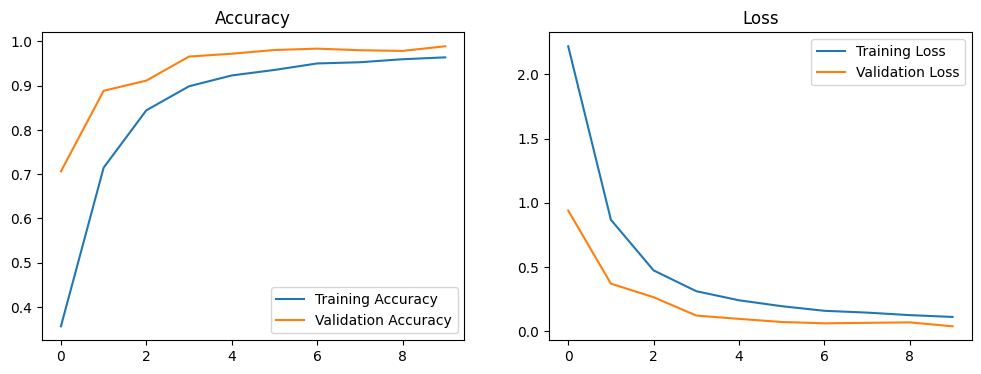

In [14]:
# 6. PLOTTING
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

## Konversi Model

In [15]:
!mkdir -p submission
model.export('submission/saved_model') # Keras 3 native export

# TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
os.makedirs('submission/tflite', exist_ok=True)
with open('submission/tflite/model.tflite', 'wb') as f:
    f.write(tflite_model)
with open('submission/tflite/label.txt', 'w') as f:
    f.write('\n'.join(sorted(train_generator.class_indices.keys())))

# TFJS & ZIP
!pip install tensorflowjs
model.save('model.h5')
!tensorflowjs_converter --input_format=keras model.h5 submission/tfjs_model
!pip freeze > submission/requirements.txt
!zip -r submission.zip submission/

print("\n✅ SEMUA KRITERIA TERPENUHI. Silakan download submission.zip")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30, 30, 3), dtype=tf.float32, name='keras_tensor_11')
Output Type:
  TensorSpec(shape=(None, 43), dtype=tf.float32, name=None)
Captures:
  136381957018192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957018768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957019728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957018960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957020112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957019920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957020496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957020304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957020880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  136381957020688: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved ar

2025-11-26 07:37:14.009161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764142634.029331    4630 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764142634.035565    4630 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1764142634.051019    4630 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764142634.051050    4630 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1764142634.051055    4630 computation_placer.cc:177] computation placer alr

## Inference (Optional)